# EMA of Curacao EV Vensim Model - FINAL EXPERIMENTS

**Purpose:** Run exploratory experiments on the Curaçao EV model and perform PRIM scenario discovery.

**This notebook:**
- Loads the Vensim model from `./model_files/`
- Runs experiments via `ema_workbench`
- Saves results to `./results/`
- Produces figures into `./figures/`

**Run order:** top → bottom, section by section. Keep the working directory at repo root.

**Sections of this NB**:
1. Set up initial experiment (of n=1500 using all 39 uncertainties)
2. Initial Exploration (of n=1500 dataset)
3. Random Forest (to reduce amount of uncertainties from 39 to at least fewer than 10)
4. Re-run experiment for 12 policy combinations and <10> uncertainties
5. Perform PRIM Scenario discovery on new, smaller dataset for upper and lower bound of scenarios

In [24]:
# --- Environment & library setup (clean) 
# ~6 seconds to run

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (
    RealParameter,
    IntegerParameter,
    CategoricalParameter,
    Constant,
    TimeSeriesOutcome,
    perform_experiments,
    save_results,
    load_results,
    ema_logging,
)
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.analysis import prim, feature_scoring, pairs_plotting, plotting

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

def print_versions() -> None:
    """Print key environment versions and paths (direct, compact)."""
    import ema_workbench  # local import to avoid polluting top-level namespace

    print(f"EMA version : {ema_workbench.__version__}")
    print(f"EMA path    : {ema_workbench.__file__}")
    print(f"NumPy       : {np.__version__}")
    print(f"Python exe  : {sys.executable}")

# Fix for older numpy versions that do not have np.NAN 
import numpy as np 
if not hasattr(np, "NAN"): np.NAN = np.nan

if __name__ == "__main__":
    ema_logging.log_to_stderr(ema_logging.INFO)
    print_versions()


EMA version : 2.5.3
EMA path    : c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\__init__.py
NumPy       : 2.3.3
Python exe  : c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\python.exe


## 1. Phase 1: Initial Experiment

In [ ]:
# EXPERIMENTAL SETUP OPEN EXPLORATION 
# for n=5000, 3.5 minutes runtime

# turn on logging
ema_logging.log_to_stderr(ema_logging.INFO) 

# instantiate a model
wd = "./model_files/" # adjust this path to load different version of model
vensim_model = VensimModel("evmodel", wd=wd, model_file="ev_curacao_model.vpmx") # "21-10 ochtend.vpmx" "20-10 eind middag.vpmx"

uncertainties = [
    # ----------------------------
    # Categorical switches
    # ----------------------------
    CategoricalParameter("Energy price switch", (1, 2, 3)),                         # 1=Stanford, 2=Twente, 3=IET
    CategoricalParameter("Fuel price switch", (1, 2, 3)),                           # 1=high, 2=medium, 3=low
    CategoricalParameter("market price scenario switch", (0, 1, 2)),                # 0=, 1=, 2=

    # --- Initial conditions Cars/EVs
    IntegerParameter("initial total cars", int(78717*0.95), int(78717*1.05)),       # 78717 ±20%
    RealParameter("initial share of EV", 0.0254075*0.9, 0.0254075*1.1),             # 

    # --- CO2 initial levels (FossilVehicle only; EV kept constant at 0)
    RealParameter("initial CO2 0 to 5 yrs[FossilVehicle]", 92, 138),                # 115 ±20%
    RealParameter("initial CO2 5 to 10 yrs[FossilVehicle]", 120, 180),              # 150 ±20%
    RealParameter("initial CO2 10 to 15 yrs[FossilVehicle]", 136, 204),             # 170 ±20%
    RealParameter("initial CO2 15 to 20 yrs[FossilVehicle]", 144, 216),             # 180 ±20%
    RealParameter("initial CO2 20 yrs plus[FossilVehicle]", 152, 228),              # 190 ±20%

    # --- Prices & costs
    RealParameter("operational", 0.3129*0.5, 0.3129*1.5),                           # 0.3129 ±50%
    RealParameter("yearly fee", 343*0.5, 343*1.5),                                  # 343 ±50%
  
    # --- Efficiency / kms driven / growth
    RealParameter("fuel efficiency", 0.11235*0.8, 0.11235*1.2),                             # (1/8.9) ±20% 
    RealParameter("Average kms driven anually[FossilVehicle]", 10000*0.7, 10000*1.3),       # 10000 ±20%
    RealParameter("Average kms driven anually[ElectricVehicle]", 10000*0.7, 10000*1.3),     # 10000 ±20%
    RealParameter('"Car park growth %"', 0.0212*0.5, 0.0212*1.1),                           # 0.0212 -50%, +10%

    # --- Charging infrastructure (constants-only items)
    RealParameter("initial value facilities[FossilVehicle]", 35*0.9, 35*1.1),       # 35 ±20%
    RealParameter("initial value facilities[ElectricVehicle]", 32*0.8, 32*1.2),     # 32 ±20%
    RealParameter("facility ratio[FossilVehicle]", 0.002*0.9, 0.002*1.1),           # 
    RealParameter("facility ratio[ElectricVehicle]", 0.2*0.5, 0.2*1.1),             # 
    RealParameter("Facility delay[FossilVehicle]", 1.5*0.7, 1.5*1.3),               # 0.9 ±20%
    RealParameter("Facility delay[ElectricVehicle]", 0.5*0.7, 1.5*0.7),             # 0.7 ±20%

    # --- Discrete choice (ASC & betas)
    RealParameter("ASC[FossilVehicle]", 0.9*0.8, 0.9*1.2),                          # 0.9 ±20%
    RealParameter("ASC[ElectricVehicle]", 0.1*0.8, 0.1*1.2),                        # 0.1 ±20%
    RealParameter("beta range", 0.00166, 0.00328),                                  # 95% confidence interval from SDC
    RealParameter("beta charging distance", -0.5, -0.06),                           #  95% confidence interval from SDC
    RealParameter("beta charge time", -0.0021, -0.00041),                           # 95% confidence interval from SDC
    RealParameter('"beta fuel/charging costs"', -0.00351, -0.00191),                # (-0.271/100) ±20% 
    RealParameter("beta car price", -5.06e-05*1.5, -5.06e-05*0.5),                  # (-7.59e-05, -2.53e-05)
    
    # --- Out-of-use rates (both vehicle types)
    RealParameter('"out of use % 0 to 5 yr"[FossilVehicle]', 0.0152, 0.0228),       # 0.019 ±20%
    RealParameter('"out of use % 5 to10 yr"[FossilVehicle]', 0.0184, 0.0276),       # 0.023 ±20%
    RealParameter('"out of use % 10 to15 yr"[FossilVehicle]', 0.0408, 0.0612),      # 0.051 ±20%
    RealParameter('"out of use % 15 to 20 yr"[FossilVehicle]', 0.1296, 0.1944),     # 0.162 ±20%
    RealParameter('"out of use % 20 yr plus"[FossilVehicle]', 0.112, 0.168),        # 0.14 ±20%

    RealParameter('"out of use % 0 to 5 yr"[ElectricVehicle]', 0.0152, 0.0228),     #
    RealParameter('"out of use % 5 to10 yr"[ElectricVehicle]', 0.0184, 0.0276),     #
    RealParameter('"out of use % 10 to15 yr"[ElectricVehicle]', 0.0408, 0.0612),    #
    RealParameter('"out of use % 15 to 20 yr"[ElectricVehicle]', 0.1296, 0.1944),   #
    RealParameter('"out of use % 20 yr plus"[ElectricVehicle]', 0.112, 0.168),      #
]

# Define policies as constants for initial run
constants = [
    # Constants can be defined here if needed
    Constant("Emission tax SWITCH", 0),
    Constant("SWITCH Policy EV Tax Cut", 0),
    Constant("Dynaf lever SWITCH", 0),  
]

# Register on the model
vensim_model.uncertainties = uncertainties 
vensim_model.constants = constants

vensim_model.outcomes = [
    TimeSeriesOutcome("Number of EVs"),
    TimeSeriesOutcome("Total CO2 emissions cars[FossilVehicle]"),
    TimeSeriesOutcome("Number of FossilVehicles"),
    ]
 
# RUN THE EXPERIMENTS
results = perform_experiments(vensim_model, 
                              scenarios=5000
                              )

# split results into experiments and outcomes
experiments, outcomes = results

[MainProcess/INFO] performing 5000 scenarios * 1 policies * 1 model(s) = 5000 experiments
100%|██████████████████████████████████████| 5000/5000 [03:34<00:00, 23.30it/s]
[MainProcess/INFO] experiments finished


#### Save/load results [comment out if not necessary]

In [3]:
# Save results  
save_results(results, "./results/results_no_POLICY.tar.gz")

c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_no_POLICY.tar.gz


In [2]:
# Load results
experiments, outcomes = load_results("./results/results_no_POLICY.tar.gz")

[MainProcess/INFO] results loaded successfully from c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_no_POLICY.tar.gz


## 2. Initial Exploration

### Pairplot

C:\Users\Amber Rozenberg\AppData\Local\Temp\ipykernel_23132\1499583372.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


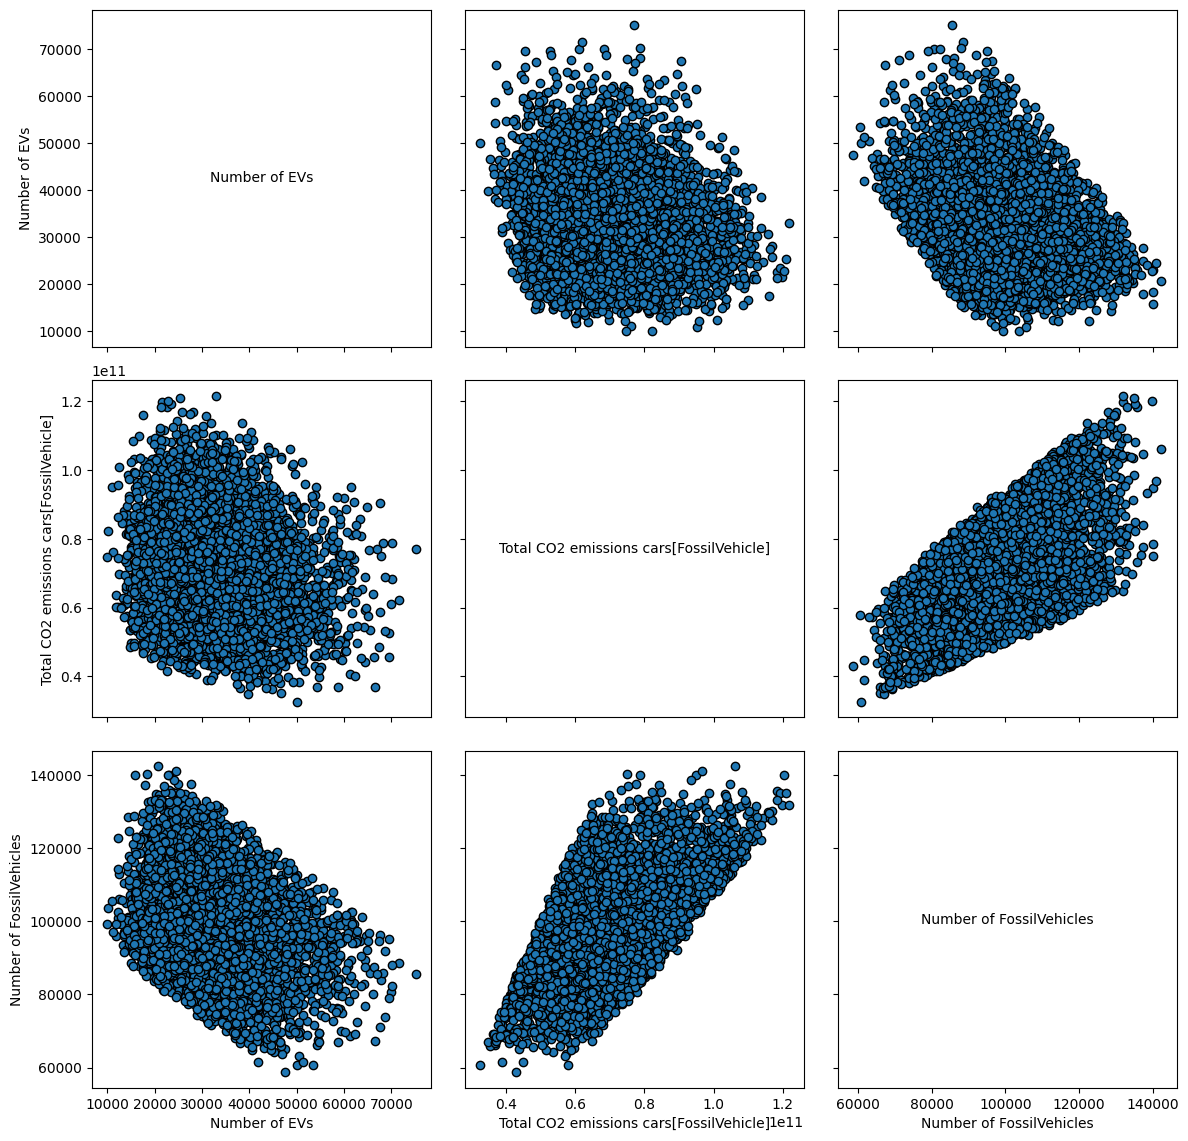

In [7]:
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, legend=False)
fig.set_size_inches(14, 14)   # larger
plt.tight_layout()
plt.show()

**Observations from scatterplots (n = 5,000 runs, all uncertainties varied)**

These scatterplots show how model outcomes co-vary when all uncertainties are varied and no policy scenarios are applied.
<br>
* 

### Runs Overview

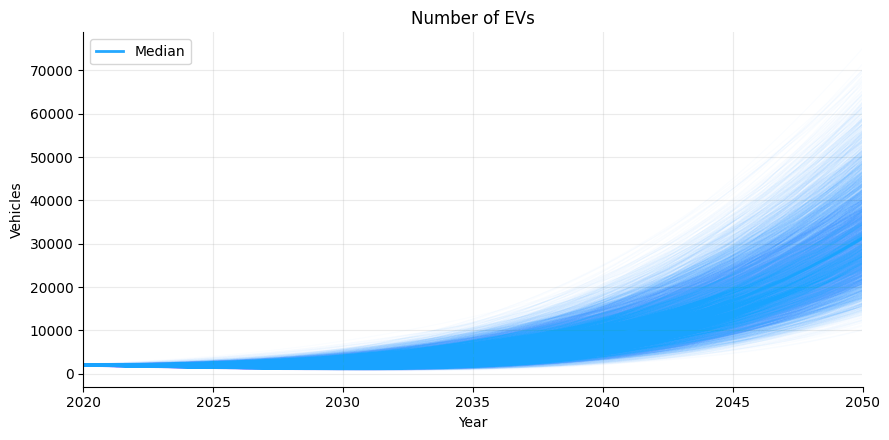

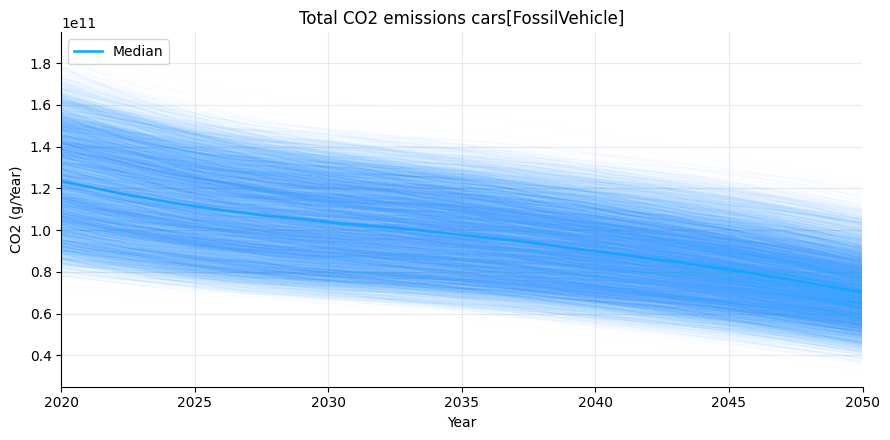

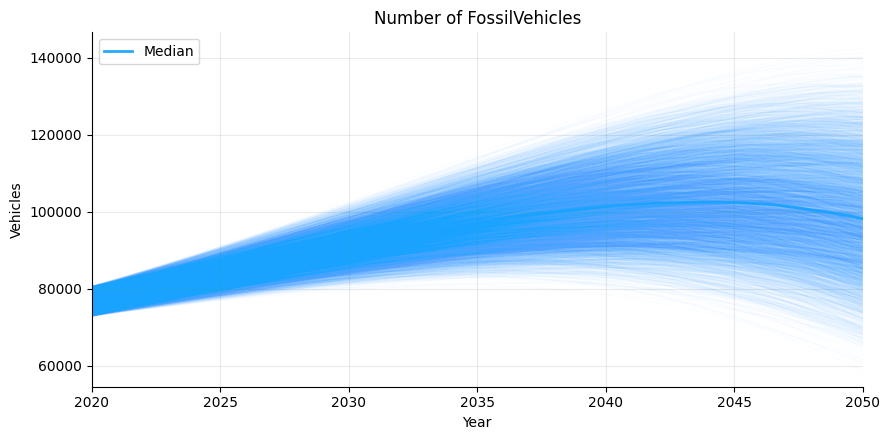

In [11]:
outcomes_of_interest = [
    "Number of EVs",
    "Total CO2 emissions cars[FossilVehicle]",
    "Number of FossilVehicles",
]

# units (adjust if needed)
units = {
    "Number of EVs": "Vehicles",
    "Total CO2 emissions cars[FossilVehicle]": "CO2 (g/Year)",
    "Number of FossilVehicles": "Vehicles",
}

def _make_time_axis_from_outcome(arr):
    T = arr.shape[1]
    for key in ("time", "TIME", "Time"):
        if key in outcomes and getattr(outcomes[key], "ndim", None) == 1 and outcomes[key].shape[0] == T:
            return outcomes[key]
    # default: inclusive years 2020..2050 mapped to T points
    return np.linspace(2020, 2050, T)

def plot_many_runs_same_colour(outcomes, outcome_names,
                               units=None,
                               upsample_factor=8,
                               base_color="#1f77b4",
                               line_alpha=0.03,
                               lw=0.8,
                               show_median=True,
                               figsize=(9, 4.5)):
    """
    Plot each outcome in outcomes_of_interest as an individual figure.
    Lines use the same colour and a low alpha so overlapping areas become brighter.
    Linear interpolation upsamples the series to smooth step-like (rectangular) data.
    """
    for outcome_name in outcome_names:
        if outcome_name not in outcomes:
            print(f"Warning: outcome '{outcome_name}' not found. Skipping.")
            continue

        arr = outcomes[outcome_name]  # expected shape (n_cases, T)
        if arr.ndim != 2:
            raise ValueError(f"Outcome '{outcome_name}' must be 2D (n_cases, T); got {arr.shape}")

        n_cases, T = arr.shape
        time = _make_time_axis_from_outcome(arr)
        # build a finer time axis for interpolation
        fine_T = int(T * upsample_factor)
        fine_time = np.linspace(time[0], time[-1], fine_T)

        fig, ax = plt.subplots(figsize=figsize)

        # plot each run interpolated to fine_time
        for i in range(n_cases):
            y = arr[i, :].astype(float)
            y_fine = np.interp(fine_time, time, y)   # linear interpolation
            ax.plot(fine_time, y_fine, color=base_color, alpha=line_alpha, linewidth=lw, solid_capstyle="round")

        # median overlay
        if show_median:
            median = np.nanmedian(arr, axis=0)
            median_fine = np.interp(fine_time, time, median)
            ax.plot(fine_time, median_fine, color=base_color, linewidth=2.0, alpha=0.95, label="Median")

        ax.set_title(outcome_name)
        ax.set_xlabel("Year")
        ax.set_ylabel(units.get(outcome_name, "Value") if units else "Value")
        ax.set_xlim(2020, 2050)
        ax.set_xticks(np.arange(2020, 2051, 5))
        ax.grid(alpha=0.25)
        if show_median:
            ax.legend(loc="upper left")
        plt.tight_layout()
        sns.despine()
        plt.show()

# Call the improved plotter (adjust parameters if you want different smoothing/alpha)
plot_many_runs_same_colour(outcomes, outcomes_of_interest, units=units,
                           upsample_factor=8, base_color="#19a3ff", line_alpha=0.02, lw=0.8)

**Interpretation of baseline uncertainty runs (n = 5,000, no policy scenario)**

These plots show how key outcomes evolve under full uncertainty without any policy interventions.
<br>

* Number of EVs: EV adoption grows exponentially after 2035 in most runs, but with wide uncertainty bands. This spread shows how sensitive adoption is to parameters like market price, car costs, and charging time.
* Total CO₂ emissions (fossil vehicles): Emissions gradually decline as EVs replace fossil vehicles. The variation across runs reflects differences in fossil fuel efficiency and fleet turnover.
* Number of fossil vehicles: Fossil vehicles initially increase slightly before stabilising or declining after 2040. This indicates that early growth in total vehicle demand can temporarily offset electrification gains.
* Overall, the ensemble shows a clear long-term transition trend toward electrification, but with high uncertainty in the pace and timing of that transition due to interacting factors in the model.

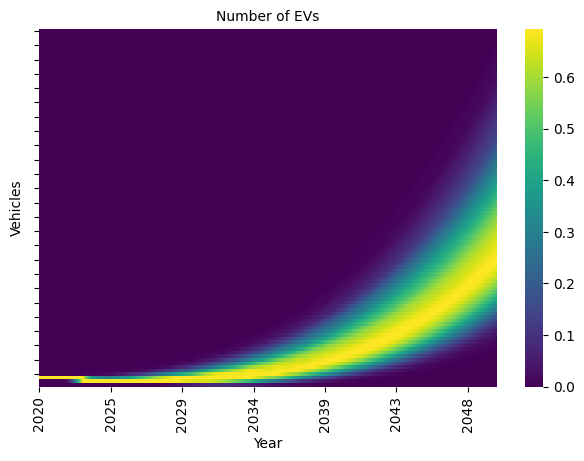

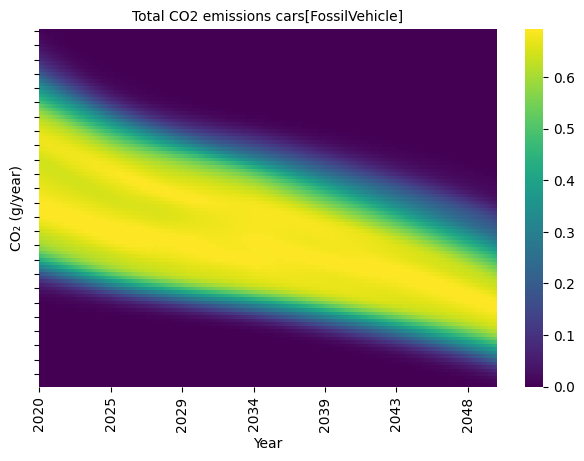

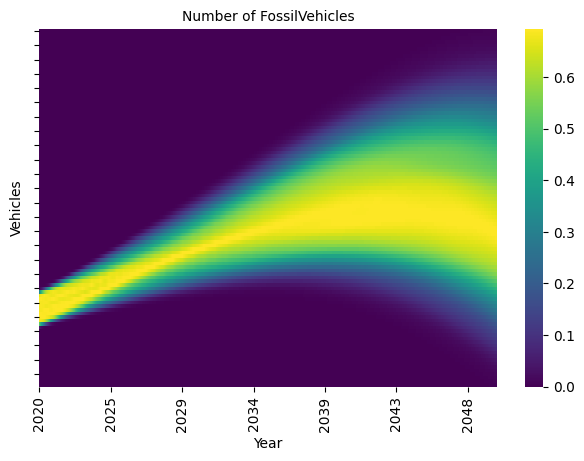

In [9]:
from ema_workbench.analysis import plotting
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator

outs = [
    "Number of EVs",
    "Total CO2 emissions cars[FossilVehicle]",
    "Number of FossilVehicles",
]

# your real time range from EMA (already years)
tvec = outcomes["TIME"][0]                 # shape (T,)
start_year, end_year = float(tvec[0]), float(tvec[-1])

units = {
    "Number of EVs": "Vehicles",
    "Total CO2 emissions cars[FossilVehicle]": "CO₂ (g/year)",
    "Number of FossilVehicles": "Vehicles",
}

for outcome in outs:
    fig, axes_map = plotting.kde_over_time(
        experiments, outcomes,
        outcomes_to_show=[outcome],
        colormap="viridis", log=True
    )
    ax = axes_map[outcome]

    # Draw once so limits are known
    fig.canvas.draw()
    xmin, xmax = ax.get_xlim()

    # Linear mapping from the *current* axis scale to calendar years
    def to_year(x):
        return start_year + (x - xmin) * (end_year - start_year) / (xmax - xmin)

    def year_formatter(x, pos):
        return f"{int(round(to_year(x)))}"

    ax.xaxis.set_major_locator(MaxNLocator(nbins=7, integer=False))
    ax.xaxis.set_major_formatter(FuncFormatter(year_formatter))
    ax.set_xlabel("Year")

    ax.set_title(outcome, fontsize=10)
    ax.set_ylabel(units.get(outcome, ""))

    plt.tight_layout(pad=1.4)
    plt.show()


**Interpretation of KDE-over-time plots (n = 5,000, no policy scenario)**

These plots show the probability density of each outcome over time under full uncertainty (no policy interventions applied). The colour intensity indicates where most runs cluster.
* Number of EVs: EV adoption shows a clear exponential growth pattern, with most runs concentrated around higher values after 2040. The widening distribution indicates increasing uncertainty in future adoption rates.
* Total CO₂ emissions (fossil vehicles): Emissions steadily decline as the fossil fleet is gradually replaced by EVs. The narrowing distribution in later years shows convergence towards lower emission levels.
* Number of fossil vehicles: Fossil vehicles initially grow slightly but start to plateau and decline after ~2040. The broadening yellow band reflects uncertainty in how quickly fossil cars are phased out.
* Together, the plots confirm a consistent transition trend: rising EV numbers, declining CO₂ emissions, and stabilising fossil vehicle use — yet with substantial variation in how fast this shift unfolds due to interacting uncertainties in market, cost, and behavioural parameters.

## 3. (Extra-Trees) Random Forest


classification and regression trees (CARTs)

**Why use Extra-Trees Random Forest for variable reduction?**
* Not all 39 variables explain all variance in the end results. For scenario discovery, we need the uncertainties that explain most of the variance.
* Random Forests work well for non-linear and interacting relationships between uncertainties and outcomes. They can handle complex dynamics without needing assumptions about how variables relate. "Works with generic LHS/Monte Carlo sampling, and with categorical uncertainties/switches"
* In this step, the Extra-Trees analysis is performed to approximate the Sobol total indices. The analysis aims to assess the importance of input parameters on the model output, considering their interactions. The Extra-Trees method is an efficient alternative to the more computationally expensive Sobol indices.
* Other methods like Sobol sensitivity analysis require thousands of runs and assume a smooth, continuous model, which isn’t practical for simulation-based models with categorical switches like Vensim.
* Computationally less expensive than Sobol
Simpler scoring methods (like correlation) miss interactions and can be misleading.
* So, Random Forest with permutation importance is a computationally efficient and interpretable way to find which uncertainties matter most.

In [4]:
# set tar
ev_final = outcomes["Number of EVs"][:, -1]  # final year values
ev_final

array([26384.252, 29932.447, 35857.426, ..., 39267.637, 25125.988,
       35381.18 ], shape=(5000,))

In [5]:
# Extra trees Random Forest (included in EMA Wbench)

#import additional libraries
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType

scores = feature_scoring.get_ex_feature_scores(experiments, ev_final,
                                      max_features=None, mode=RuleInductionType.REGRESSION,
                                      nr_trees=250,
                                      random_state=42)[0] # 
scores

1
0                                                    
market price scenario switch                 0.259476
beta car price                               0.235001
"Car park growth %"                          0.128948
beta charge time                             0.076954
beta range                                   0.043886
ASC[FossilVehicle]                           0.038536
beta charging distance                       0.014793
initial value facilities[ElectricVehicle]    0.010680
initial total cars                           0.009327
"out of use % 20 yr plus"[FossilVehicle]     0.008505
initial value facilities[FossilVehicle]      0.007725
facility ratio[ElectricVehicle]              0.006697
"out of use % 5 to10 yr"[FossilVehicle]      0.006221
"out of use % 0 to 5 yr"[FossilVehicle]      0.006197
"out of use % 10 to15 yr"[FossilVehicle]     0.006190
Fuel price switch                            0.006172
Energy price switch                          0.006129
initial share of EV                          0.006099
"out of use % 15 to 20 yr"[FossilVehicle]    0.006040
Facility delay[ElectricVehicle]              0.006038
Average kms driven anually[FossilVehicle]    0.006034
"out of use % 15 to 20 yr"[ElectricVehicle]  0.005962
"out of use % 5 to10 yr"[ElectricVehicle]    0.005932
"beta fuel/charging costs"                   0.005908
initial CO2 15 to 20 yrs[FossilVehicle]      0.005904
"out of use % 0 to 5 yr"[ElectricVehicle]    0.005877
initial CO2 0 to 5 yrs[FossilVehicle]        0.005859
initial CO2 5 to 10 yrs[FossilVehicle]       0.005845
fuel efficiency                              0.005802
Average kms driven anually[ElectricVehicle]  0.005792
initial CO2 20 yrs plus[FossilVehicle]       0.005763
"out of use % 10 to15 yr"[ElectricVehicle]   0.005760
Facility delay[FossilVehicle]                0.005759
ASC[ElectricVehicle]                         0.005721
operational                                  0.005717
yearly fee                                   0.005710
"out of use % 20 yr plus"[ElectricVehicle]   0.005709
initial CO2 10 to 15 yrs[FossilVehicle]      0.005698
facility ratio[FossilVehicle]                0.005633

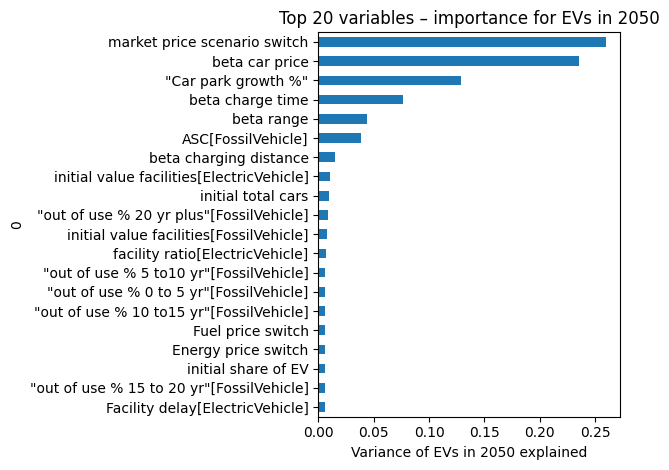

In [6]:
# plot importances from Extra Trees Feature Scoring
scores.head(20).plot(kind="barh", legend=False)
plt.gca().invert_yaxis()
plt.title("Top 20 variables – importance for EVs in 2050")
plt.xlabel("Variance of EVs in 2050 explained")
plt.tight_layout()
plt.show()


**Why use Extra Trees Random Forest?**
* Experiments use LHS and switches (non-continuous variables), making Sobol or Extra Trees Random Forst Regression the best 2 options
* Sobol = computationally expensive, but Extra Trees Random Forest often wields same results with way less computational power.

Therefore, decided on RF.

**Which variables are dropped?**
* The top 6 variables explain most of the variation in EV adoption by 2050. These have a clear impact on model performance, while the rest add little explanatory power.
* We want to include the top 15 for PRIM Analysis
* The final set therefore focuses on behavioural, economic, and policy-related uncertainties—those most relevant for exploring EV transition dynamics.

In [23]:
# print final set

scores.head(15)

1
0                                                  
market price scenario switch               0.259476
beta car price                             0.235001
"Car park growth %"                        0.128948
beta charge time                           0.076954
beta range                                 0.043886
ASC[FossilVehicle]                         0.038536
beta charging distance                     0.014793
initial value facilities[ElectricVehicle]  0.010680
initial total cars                         0.009327
"out of use % 20 yr plus"[FossilVehicle]   0.008505
initial value facilities[FossilVehicle]    0.007725
facility ratio[ElectricVehicle]            0.006697
"out of use % 5 to10 yr"[FossilVehicle]    0.006221
"out of use % 0 to 5 yr"[FossilVehicle]    0.006197
"out of use % 10 to15 yr"[FossilVehicle]   0.006190

## 4. Phase 2: Re-Run with fewer uncertainties and policies

In [25]:
# instantiate a model
wd = "./model_files/" # adjust this path to load different version of model
vensim_model = VensimModel("evmodel", wd=wd, model_file="ev_curacao_model.vpmx") 

uncertainties = [
    # ----------------------------
    # Categorical switches
    # ----------------------------
#    CategoricalParameter("Energy price switch", (1, 2, 3)),                         # 1=Stanford, 2=Twente, 3=IET
#    CategoricalParameter("Fuel price switch", (1, 2, 3)),                           # 1=high, 2=medium, 3=low
    CategoricalParameter("market price scenario switch", (0, 1, 2)),                # 0=, 1=, 2=

    # --- Initial conditions Cars/EVs
    IntegerParameter("initial total cars", int(78717*0.95), int(78717*1.05)),       # 78717 ±20%
#    RealParameter("initial share of EV", 0.0254075*0.9, 0.0254075*1.1),             # 

    # --- CO2 initial levels (FossilVehicle only; EV kept constant at 0)
#    RealParameter("initial CO2 0 to 5 yrs[FossilVehicle]", 92, 138),                # 115 ±20%
#    RealParameter("initial CO2 5 to 10 yrs[FossilVehicle]", 120, 180),              # 150 ±20%
#    RealParameter("initial CO2 10 to 15 yrs[FossilVehicle]", 136, 204),             # 170 ±20%
#    RealParameter("initial CO2 15 to 20 yrs[FossilVehicle]", 144, 216),             # 180 ±20%
#    RealParameter("initial CO2 20 yrs plus[FossilVehicle]", 152, 228),              # 190 ±20%

    # --- Prices & costs
#    RealParameter("operational", 0.3129*0.5, 0.3129*1.5),                           # 0.3129 ±50%
#    RealParameter("yearly fee", 343*0.5, 343*1.5),                                  # 343 ±50%
  
    # --- Efficiency / kms driven / growth
#    RealParameter("fuel efficiency", 0.11235*0.8, 0.11235*1.2),                             # (1/8.9) ±20% 
#    RealParameter("Average kms driven anually[FossilVehicle]", 10000*0.7, 10000*1.3),       # 10000 ±20%
#    RealParameter("Average kms driven anually[ElectricVehicle]", 10000*0.7, 10000*1.3),     # 10000 ±20%
    RealParameter('"Car park growth %"', 0.0212*0.5, 0.0212*1.1),                           # 0.0212 -50%, +10%

    # --- Charging infrastructure (constants-only items)
    RealParameter("initial value facilities[FossilVehicle]", 35*0.9, 35*1.1),       # 35 ±20%
    RealParameter("initial value facilities[ElectricVehicle]", 32*0.8, 32*1.2),     # 32 ±20%
#    RealParameter("facility ratio[FossilVehicle]", 0.002*0.9, 0.002*1.1),           # 
    RealParameter("facility ratio[ElectricVehicle]", 0.2*0.5, 0.2*1.1),             # 
#    RealParameter("Facility delay[FossilVehicle]", 1.5*0.7, 1.5*1.3),               # 0.9 ±20%
#    RealParameter("Facility delay[ElectricVehicle]", 0.5*0.7, 1.5*0.7),             # 0.7 ±20%

    # --- Discrete choice (ASC & betas)
    RealParameter("ASC[FossilVehicle]", 0.9*0.8, 0.9*1.2),                          # 0.9 ±20%
#    RealParameter("ASC[ElectricVehicle]", 0.1*0.8, 0.1*1.2),                        # 0.1 ±20%
    RealParameter("beta range", 0.00166, 0.00328),                                  # 95% confidence interval from SDC
    RealParameter("beta charging distance", -0.5, -0.06),                           #  95% confidence interval from SDC
    RealParameter("beta charge time", -0.0021, -0.00041),                           # 95% confidence interval from SDC
#    RealParameter('"beta fuel/charging costs"', -0.00351, -0.00191),                # (-0.271/100) ±20% 
    RealParameter("beta car price", -5.06e-05*1.5, -5.06e-05*0.5),                  # (-7.59e-05, -2.53e-05)
    
    # --- Out-of-use rates (both vehicle types)
    RealParameter('"out of use % 0 to 5 yr"[FossilVehicle]', 0.0152, 0.0228),       # 0.019 ±20%
    RealParameter('"out of use % 5 to10 yr"[FossilVehicle]', 0.0184, 0.0276),       # 0.023 ±20%
    RealParameter('"out of use % 10 to15 yr"[FossilVehicle]', 0.0408, 0.0612),      # 0.051 ±20%
#    RealParameter('"out of use % 15 to 20 yr"[FossilVehicle]', 0.1296, 0.1944),     # 0.162 ±20%
    RealParameter('"out of use % 20 yr plus"[FossilVehicle]', 0.112, 0.168),        # 0.14 ±20%

#    RealParameter('"out of use % 0 to 5 yr"[ElectricVehicle]', 0.0152, 0.0228),     #
#    RealParameter('"out of use % 5 to10 yr"[ElectricVehicle]', 0.0184, 0.0276),     #
#    RealParameter('"out of use % 10 to15 yr"[ElectricVehicle]', 0.0408, 0.0612),    #
#    RealParameter('"out of use % 15 to 20 yr"[ElectricVehicle]', 0.1296, 0.1944),   #
#    RealParameter('"out of use % 20 yr plus"[ElectricVehicle]', 0.112, 0.168),      #
]


# Register on the model
vensim_model.uncertainties = uncertainties #+ policy_levers
#vensim_model.levers = policy_levers 
vensim_model.constants = constants # []

vensim_model.outcomes = [
    TimeSeriesOutcome("Number of EVs"),
    TimeSeriesOutcome("Total CO2 emissions cars[FossilVehicle]"),
    TimeSeriesOutcome("Number of FossilVehicles"),
    ]
 
# RUN THE EXPERIMENTS
results = perform_experiments(vensim_model, 
                              scenarios=10000 
                              )

# split results into experiments and outcomes
experiments, outcomes = results

[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
100%|████████████████████████████████████| 10000/10000 [06:11<00:00, 26.90it/s]
[MainProcess/INFO] experiments finished


In [69]:
#experiments.head()

In [26]:
# Save results  
save_results(results, "./results/results_PRIM_NO_POLICY.tar.gz")

c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_PRIM_NO_POLICY.tar.gz


In [36]:
# Load results
experiments, outcomes = load_results("./results/results_PRIM_NO_POLICY.tar.gz")

[MainProcess/INFO] results loaded successfully from c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_PRIM_NO_POLICY.tar.gz


### Initial Exploration

C:\Users\Amber Rozenberg\AppData\Local\Temp\ipykernel_23132\2032926390.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend(
C:\Users\Amber Rozenberg\AppData\Local\Temp\ipykernel_23132\2032926390.py:15: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend


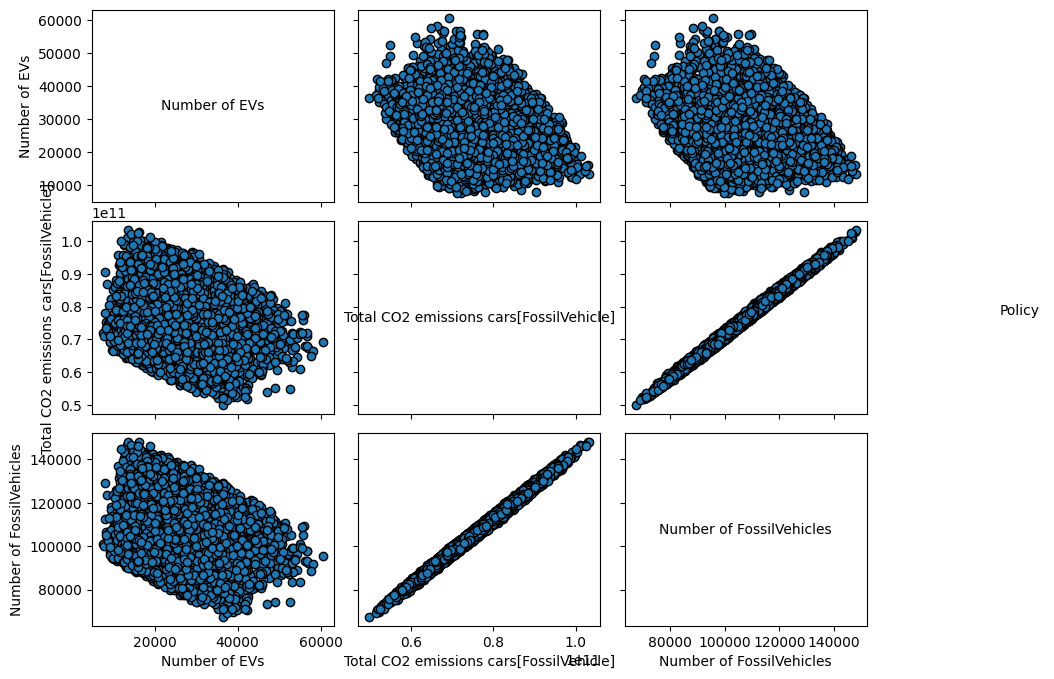

In [37]:
# Initial Exploration, colour-coded by policy?
fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, legend=True,  
    alpha=0.3, s=10,
)
fig.set_size_inches(8, 8)

fig.legend(
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    title='Policy',
    frameon=False,
)
fig.set_size_inches(10, 8)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # leave space for legend

plt.show()

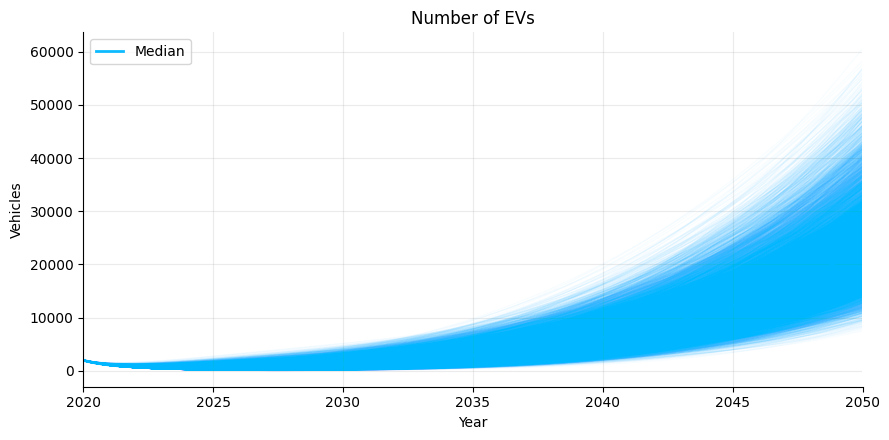

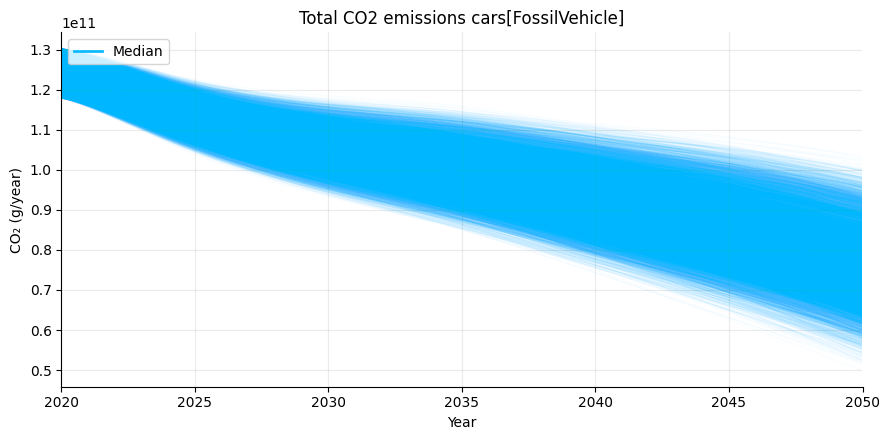

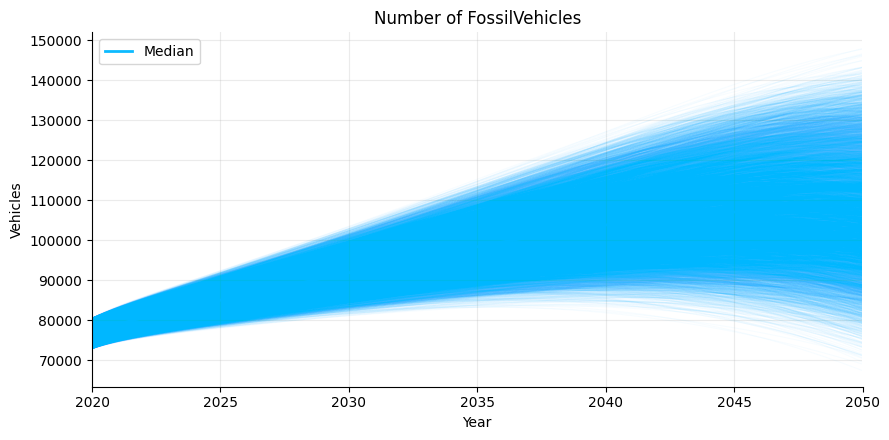

In [ ]:
# plot the outcomes of interest as line graphs
plot_many_runs_same_colour(outcomes, outcomes_of_interest, units=units,
                           upsample_factor=8, base_color="#00B7FF9E", line_alpha=0.01, lw=0.8)

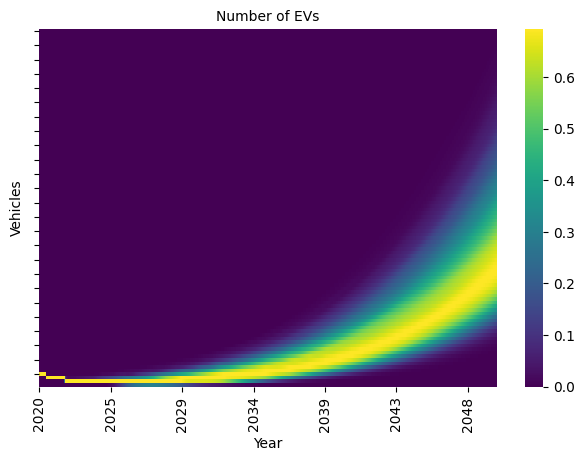

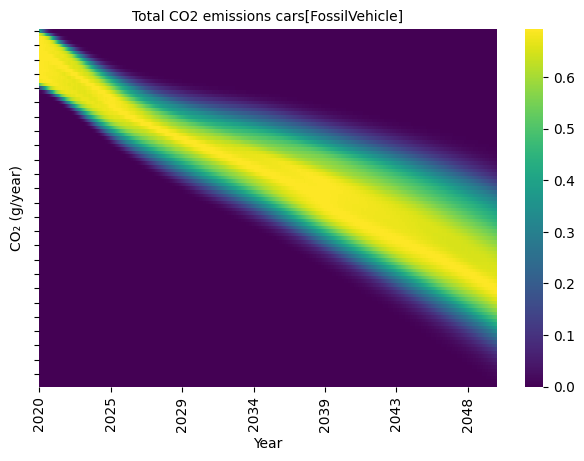

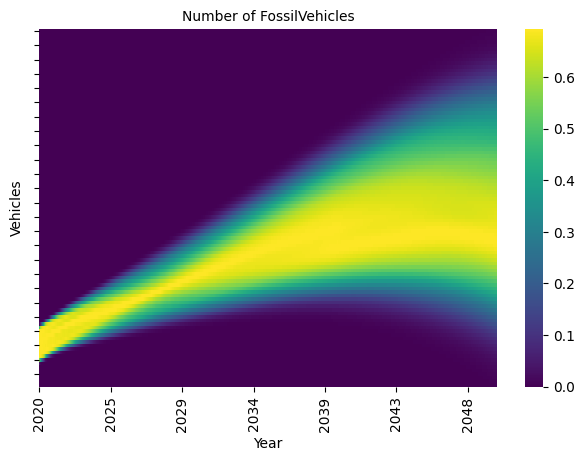

In [29]:
outs = [
    "Number of EVs",
    "Total CO2 emissions cars[FossilVehicle]",
    "Number of FossilVehicles",
]

# your real time range from EMA (already years)
tvec = outcomes["TIME"][0]                 # shape (T,)
start_year, end_year = float(tvec[0]), float(tvec[-1])

units = {
    "Number of EVs": "Vehicles",
    "Total CO2 emissions cars[FossilVehicle]": "CO₂ (g/year)",
    "Number of FossilVehicles": "Vehicles",
}

for outcome in outs:
    fig, axes_map = plotting.kde_over_time(
        experiments, outcomes,
        outcomes_to_show=[outcome],
        colormap="viridis", log=True
    )
    ax = axes_map[outcome]

    # Draw once so limits are known
    fig.canvas.draw()
    xmin, xmax = ax.get_xlim()

    # Linear mapping from the *current* axis scale to calendar years
    def to_year(x):
        return start_year + (x - xmin) * (end_year - start_year) / (xmax - xmin)

    def year_formatter(x, pos):
        return f"{int(round(to_year(x)))}"

    ax.xaxis.set_major_locator(MaxNLocator(nbins=7, integer=False))
    ax.xaxis.set_major_formatter(FuncFormatter(year_formatter))
    ax.set_xlabel("Year")

    ax.set_title(outcome, fontsize=10)
    ax.set_ylabel(units.get(outcome, ""))

    plt.tight_layout(pad=1.4)
    plt.show()


## 5. Scenario Discovery

### Patient-Rule Induction Method (PRIM)

#### LOW EV SCENARIO

In [38]:
x = experiments

ev_ts = outcomes["Number of EVs"]
final_evs = ev_ts[:, -1] # pick the last time step (or the column == 30 if your columns are time labels)

cutoff_lo = np.percentile(final_evs, 20)   # 20th percentile
y = final_evs < cutoff_lo                  # explicitly asking PRIM to find combinations of inputs that characterise low EV adoption scenarios.

In [39]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category
[MainProcess/INFO] 10000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 0.9192307692307692, mass: 0.052, coverage: 0.239, density: 0.9192307692307692 restricted_dimensions: 7


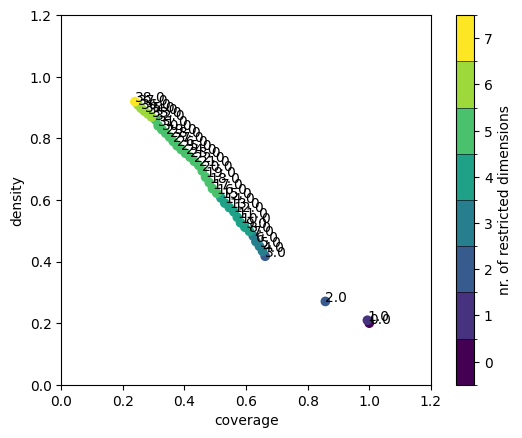

In [40]:
box1.show_tradeoff(annotated=True)
plt.show()

**Trade-off plot:**
* This plot visualises the trade-off between coverage (how much of the low-EV adoption cases are captured) and density (how pure those cases are). Each numbered point represents a potential PRIM box, with colour indicating how many uncertainties are constrained in that box.
* The “elbow” around boxes 15–18 marks a good balance — these boxes capture a large portion of low-EV scenarios while maintaining high internal consistency. Beyond that point, increasing density further would require sharply reducing coverage.

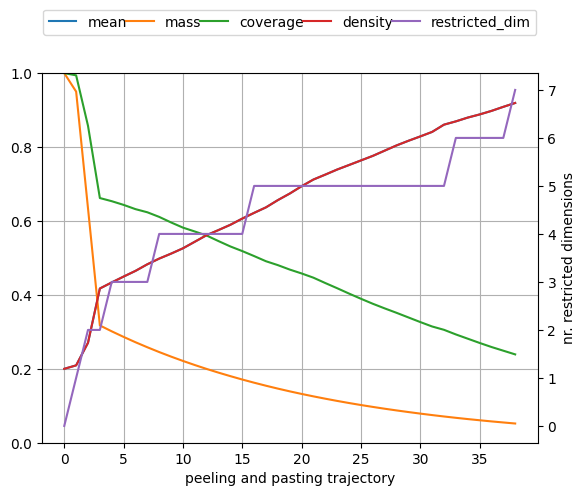

In [41]:
box1.show_ppt();

[<Figure size 640x480 with 1 Axes>]

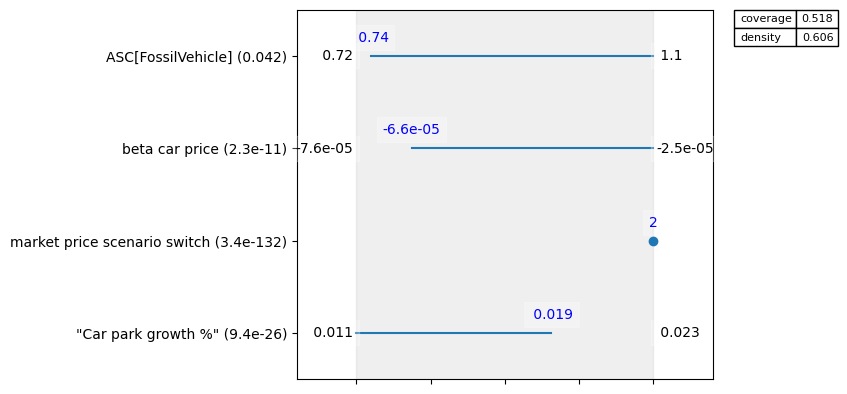

In [42]:
box1.inspect(15, style='graph')

**Interpretation**
* txt

Restricted variables:

* 
* 
* 
* 
* 

**Interpretation for stakeholder**

Low EV adoption occurs in model when:

* 
* 
* 
* 
* 

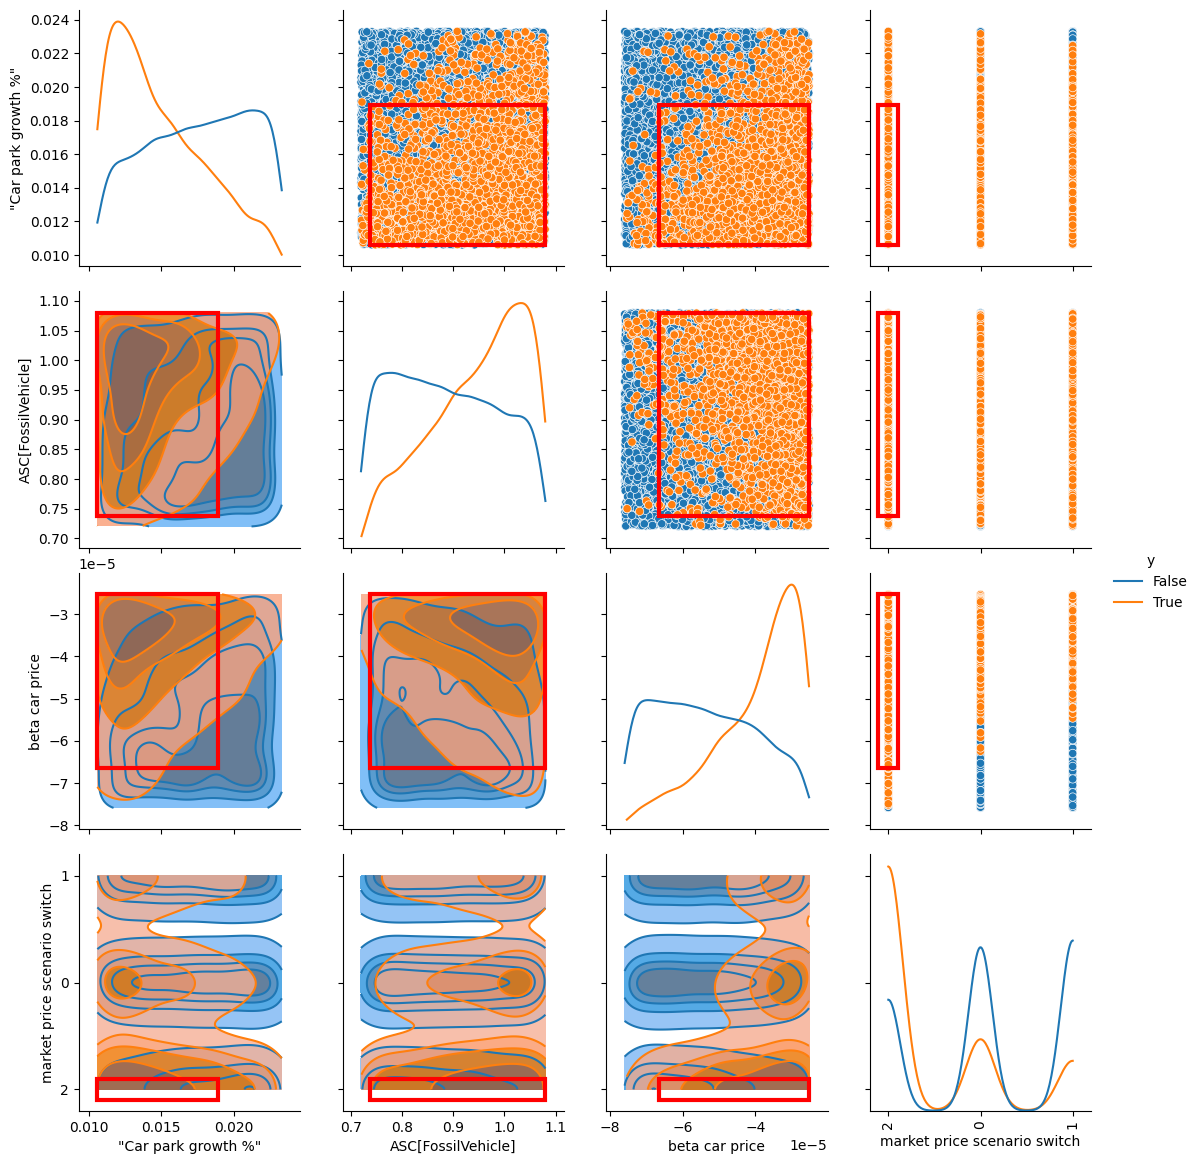

In [ ]:
# Scatter plot of box boundaries, for n=2400 takes ~ 1 min
k = 15

box1.select(k)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

**Peeling and pasting trajectory**
* This figure shows how PRIM gradually narrows down the uncertainty space to isolate the conditions that lead to low EV adoption in 2050.
As the algorithm “peels,” mass (box size) decreases and density increases, meaning the subset becomes smaller but more representative of low-EV outcomes. The number of restricted dimensions rises as more uncertainties (e.g., car price sensitivity, market scenario, charging time) are fixed to specific ranges.
* The selected box (e.g. Box 16) therefore represents the most meaningful combination of uncertainty conditions explaining where and why EV adoption remains low by 2050.

#### HIGH EV SCENARIO

In [44]:
x = experiments

ev_ts = outcomes["Number of EVs"]
final_evs = ev_ts[:, -1] # pick the last time step (or the column == 30 if your columns are time labels)

cutoff_hi = np.percentile(final_evs, 80)   # 20th percentile
y = final_evs > cutoff_hi                  # explicitly asking PRIM to find combinations of inputs that characterise low EV adoption scenarios.

In [45]:
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] column policy dropped from analysis because it has only one category
[MainProcess/INFO] column model dropped from analysis because it has only one category


[MainProcess/INFO] 10000 points remaining, containing 2000 cases of interest
[MainProcess/INFO] mean: 0.9826589595375722, mass: 0.0519, coverage: 0.255, density: 0.9826589595375722 restricted_dimensions: 7


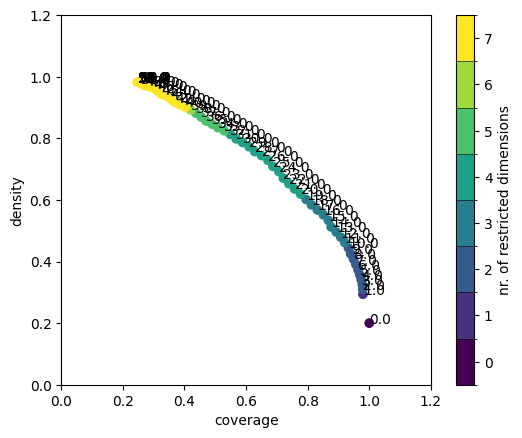

In [46]:
box1.show_tradeoff(annotated=True)
plt.show()

**Trade-off plot**
* txt
* 

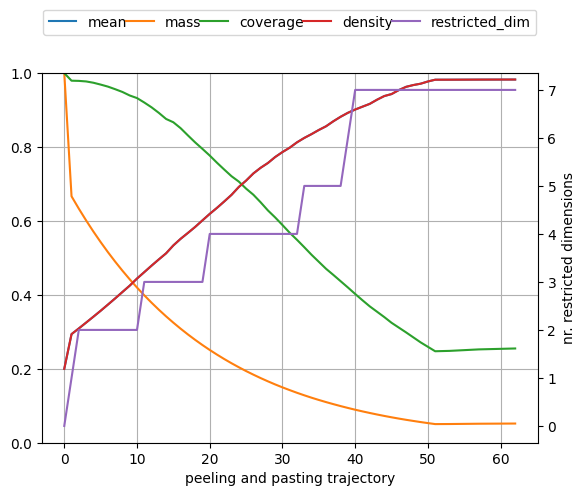

In [47]:
box1.show_ppt() ;

**Peeling and pasting trajectory**

* txt

[<Figure size 640x480 with 1 Axes>]

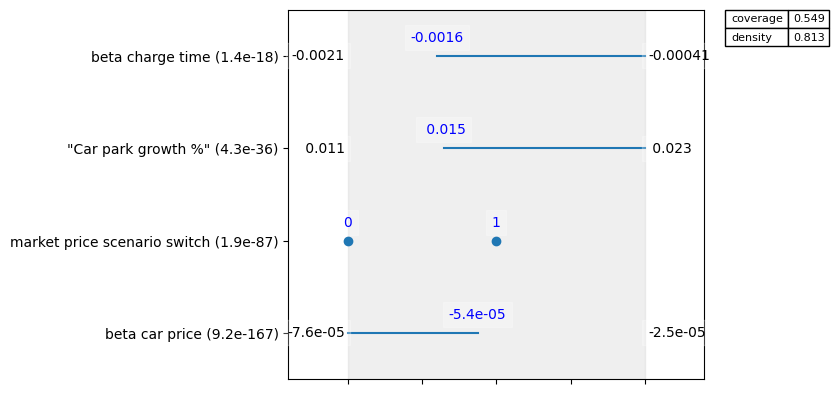

In [ ]:
# inspect the 'elbow' box
# PICK THIS ONE
box1.inspect(32, style='graph')

**Interpretation**
Coverage = x.xx, Density = x.xx → 

Restricted variables:
* txt

**Interpretation for stakeholders**
* txt


**Why this box was chosen:**


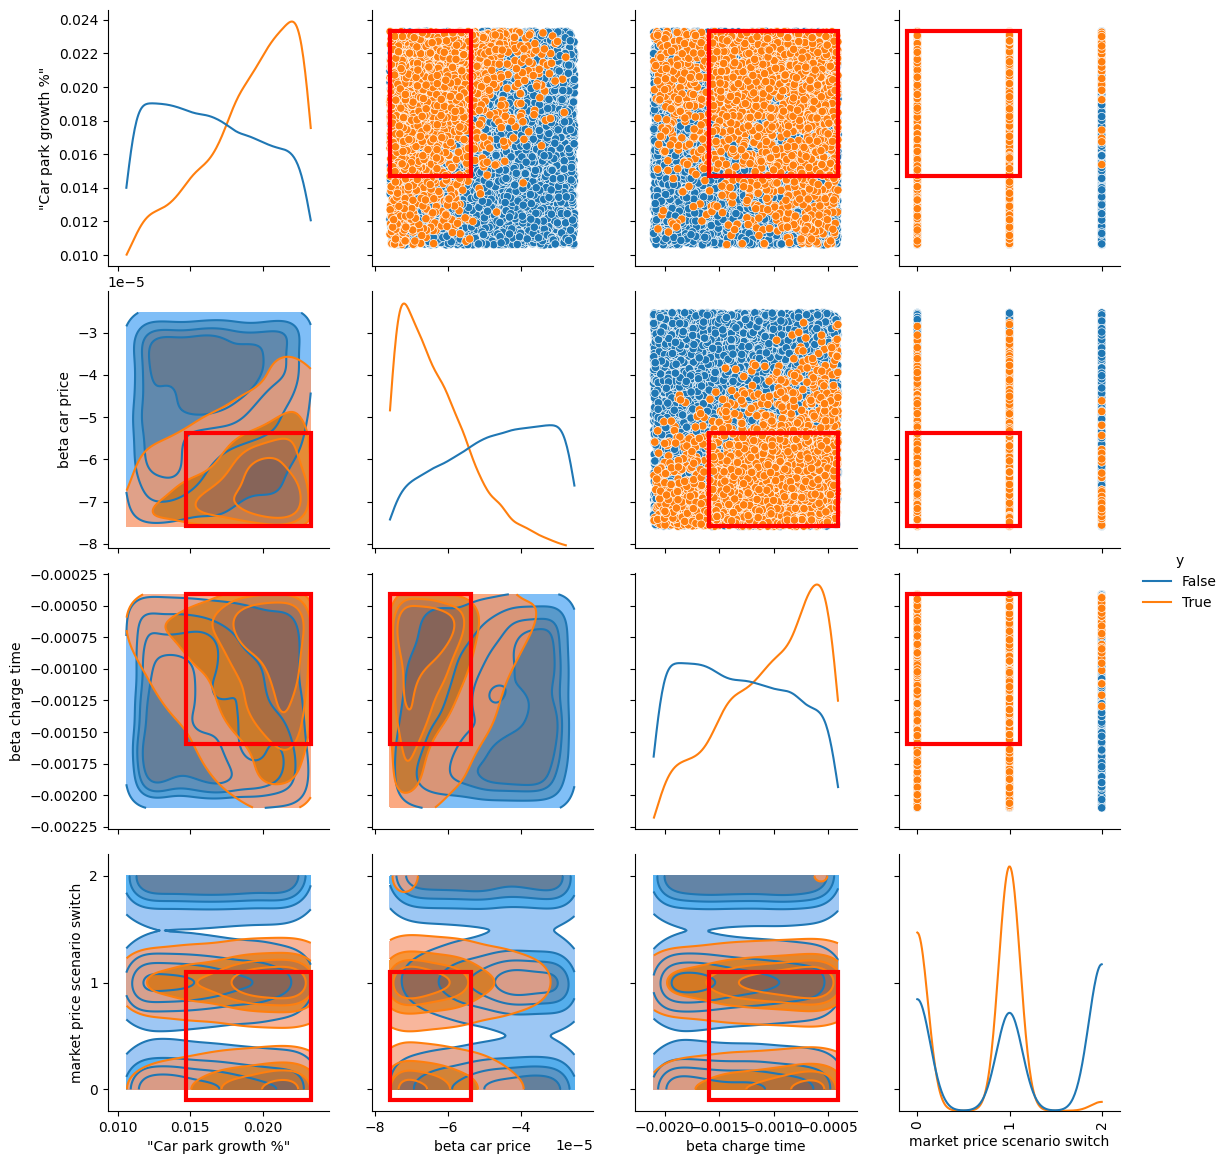

In [51]:
# Scatter plot of box boundaries, for n=2400 takes ~ 1 min
j = 32

box1.select(j)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

**Interpretation of PRIM box for high EV adoption in 2050**

This pairwise scatter and density plot shows the interactions between the key uncertainties in the high EV adoption region (orange). The red boxes represent the boundaries of the PRIM box that characterises the conditions leading to strong EV growth by 2050.

* txt

### Plot some nice lines on scenarios we found in PRIM

In [32]:
def plot_ev_low_high_envelopes(outcomes,
                               outcome_name="Number of EVs",
                               low_q=20, high_q=80,
                               upsample_factor=8,
                               low_colour="#d62728",   # red-ish
                               high_colour="#2ca02c",  # green-ish
                               alpha=0.35,
                               figsize=(9, 4.5)):
    """
    Plot semi-transparent envelopes for the lowest and highest 20% groups
    (based on final-year EV count). No individual lines.
    """

    if outcome_name not in outcomes:
        raise KeyError(f"Outcome '{outcome_name}' not found in outcomes dict")

    arr = outcomes[outcome_name]                     # shape (n_cases, T)
    if arr.ndim != 2:
        raise ValueError(f"'{outcome_name}' must be 2D (n_cases, T); got {arr.shape}")

    n_cases, T = arr.shape
    time = _make_time_axis_from_outcome(arr)

    # --- define low/high groups by final timestep (2050) ---
    final_vals = arr[:, -1].astype(float)
    low_cut  = np.percentile(final_vals, low_q)
    high_cut = np.percentile(final_vals, high_q)
    low_mask  = final_vals <= low_cut
    high_mask = final_vals >= high_cut

    # --- interpolation ---
    fine_T = int(T * upsample_factor)
    fine_time = np.linspace(time[0], time[-1], fine_T)

    def _interp_runs(A):
        Y = np.empty((A.shape[0], fine_T), dtype=float)
        for i in range(A.shape[0]):
            Y[i] = np.interp(fine_time, time, A[i].astype(float))
        return Y

    A_low  = _interp_runs(arr[low_mask, :])
    A_high = _interp_runs(arr[high_mask, :])

    # --- compute envelope bounds ---
    low_min, low_max = np.nanmin(A_low, axis=0), np.nanmax(A_low, axis=0)
    high_min, high_max = np.nanmin(A_high, axis=0), np.nanmax(A_high, axis=0)

    # --- plot ---
    fig, ax = plt.subplots(figsize=figsize)

    # background for reference (optional)
    ax.fill_between(fine_time, low_min, low_max, color=low_colour, alpha=alpha,
                    label=f"Lowest {low_q}% (range)")
    ax.fill_between(fine_time, high_min, high_max, color=high_colour, alpha=alpha,
                    label=f"Highest {100 - high_q}% (range)")

    # outline for clarity
    ax.plot(fine_time, low_min, color=low_colour, lw=1.0)
    ax.plot(fine_time, low_max, color=low_colour, lw=1.0)
    ax.plot(fine_time, high_min, color=high_colour, lw=1.0)
    ax.plot(fine_time, high_max, color=high_colour, lw=1.0)

    # styling
    ax.set_title(f"{outcome_name} — lowest vs highest 20th percentiles")
    ax.set_xlabel("Year")
    ax.set_ylabel("Vehicles")
    ax.set_xlim(time[0], time[-1])
    try:
        ax.set_xticks(np.arange(2020, 2051, 5))
    except Exception:
        pass
    ax.grid(alpha=0.25)
    ax.legend(loc="upper left")
    sns.despine()
    plt.tight_layout()
    plt.show()


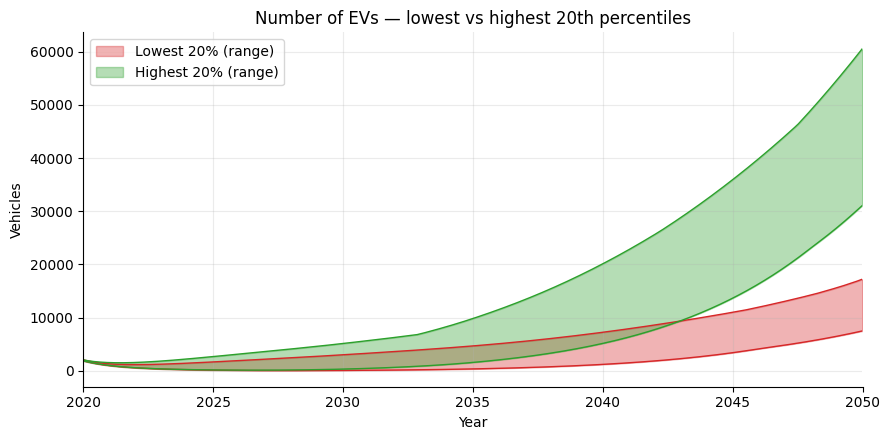

In [33]:
plot_ev_low_high_envelopes(outcomes)

## 6. Phase 3: Policy Ensembles

In [30]:
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench import Policy

# instantiate a model
wd = "./model_files/" # adjust this path to load different version of model
vensim_model = VensimModel("evmodel", wd=wd, model_file="ev_curacao_model.vpmx") 

uncertainties = [
    # ----------------------------
    # Categorical switches
    # ----------------------------
    CategoricalParameter("Energy price switch", (1, 2, 3)),                         # 1=Stanford, 2=Twente, 3=IET
    CategoricalParameter("Fuel price switch", (1, 2, 3)),                           # 1=high, 2=medium, 3=low
    CategoricalParameter("market price scenario switch", (0, 1, 2)),                # 0=, 1=, 2=

    # --- Initial conditions Cars/EVs
    IntegerParameter("initial total cars", int(78717*0.95), int(78717*1.05)),       # 78717 ±20%
    RealParameter("initial share of EV", 0.0254075*0.9, 0.0254075*1.1),             # 

    # --- CO2 initial levels (FossilVehicle only; EV kept constant at 0)
    RealParameter("initial CO2 0 to 5 yrs[FossilVehicle]", 92, 138),                # 115 ±20%
    RealParameter("initial CO2 5 to 10 yrs[FossilVehicle]", 120, 180),              # 150 ±20%
    RealParameter("initial CO2 10 to 15 yrs[FossilVehicle]", 136, 204),             # 170 ±20%
    RealParameter("initial CO2 15 to 20 yrs[FossilVehicle]", 144, 216),             # 180 ±20%
    RealParameter("initial CO2 20 yrs plus[FossilVehicle]", 152, 228),              # 190 ±20%

    # --- Prices & costs
    RealParameter("operational", 0.3129*0.5, 0.3129*1.5),                           # 0.3129 ±50%
    RealParameter("yearly fee", 343*0.5, 343*1.5),                                  # 343 ±50%
  
    # --- Efficiency / kms driven / growth
    RealParameter("fuel efficiency", 0.11235*0.8, 0.11235*1.2),                             # (1/8.9) ±20% 
    RealParameter("Average kms driven anually[FossilVehicle]", 10000*0.7, 10000*1.3),       # 10000 ±20%
    RealParameter("Average kms driven anually[ElectricVehicle]", 10000*0.7, 10000*1.3),     # 10000 ±20%
    RealParameter('"Car park growth %"', 0.0212*0.5, 0.0212*1.1),                           # 0.0212 -50%, +10%

    # --- Charging infrastructure (constants-only items)
    RealParameter("initial value facilities[FossilVehicle]", 35*0.9, 35*1.1),       # 35 ±20%
    RealParameter("initial value facilities[ElectricVehicle]", 32*0.8, 32*1.2),     # 32 ±20%
    RealParameter("facility ratio[FossilVehicle]", 0.002*0.9, 0.002*1.1),           # 
    RealParameter("facility ratio[ElectricVehicle]", 0.2*0.5, 0.2*1.1),             # 
    RealParameter("Facility delay[FossilVehicle]", 1.5*0.7, 1.5*1.3),               # 0.9 ±20%
    RealParameter("Facility delay[ElectricVehicle]", 0.5*0.7, 1.5*0.7),             # 0.7 ±20%

    # --- Discrete choice (ASC & betas)
    RealParameter("ASC[FossilVehicle]", 0.9*0.8, 0.9*1.2),                          # 0.9 ±20%
    RealParameter("ASC[ElectricVehicle]", 0.1*0.8, 0.1*1.2),                        # 0.1 ±20%
    RealParameter("beta range", 0.00166, 0.00328),                                  # 95% confidence interval from SDC
    RealParameter("beta charging distance", -0.5, -0.06),                           #  95% confidence interval from SDC
    RealParameter("beta charge time", -0.0021, -0.00041),                           # 95% confidence interval from SDC
    RealParameter('"beta fuel/charging costs"', -0.00351, -0.00191),                # (-0.271/100) ±20% 
    RealParameter("beta car price", -5.06e-05*1.5, -5.06e-05*0.5),                  # (-7.59e-05, -2.53e-05)
    
    # --- Out-of-use rates (both vehicle types)
    RealParameter('"out of use % 0 to 5 yr"[FossilVehicle]', 0.0152, 0.0228),       # 0.019 ±20%
    RealParameter('"out of use % 5 to10 yr"[FossilVehicle]', 0.0184, 0.0276),       # 0.023 ±20%
    RealParameter('"out of use % 10 to15 yr"[FossilVehicle]', 0.0408, 0.0612),      # 0.051 ±20%
    RealParameter('"out of use % 15 to 20 yr"[FossilVehicle]', 0.1296, 0.1944),     # 0.162 ±20%
    RealParameter('"out of use % 20 yr plus"[FossilVehicle]', 0.112, 0.168),        # 0.14 ±20%

    RealParameter('"out of use % 0 to 5 yr"[ElectricVehicle]', 0.0152, 0.0228),     #
    RealParameter('"out of use % 5 to10 yr"[ElectricVehicle]', 0.0184, 0.0276),     #
    RealParameter('"out of use % 10 to15 yr"[ElectricVehicle]', 0.0408, 0.0612),    #
    RealParameter('"out of use % 15 to 20 yr"[ElectricVehicle]', 0.1296, 0.1944),   #
    RealParameter('"out of use % 20 yr plus"[ElectricVehicle]', 0.112, 0.168),      #
]

vensim_model.outcomes = [
    TimeSeriesOutcome("Number of EVs"),
    TimeSeriesOutcome("Total CO2 emissions cars[FossilVehicle]"),
    TimeSeriesOutcome("Number of FossilVehicles"),
    ]
 
policies = [
    Policy("Base", **{
        "SWITCH Policy EV Tax Cut": 0,
        "Emission tax SWITCH": 0,
        "Dynaf lever SWITCH": 0,
    }),
    Policy("EVTax_ON", **{
        "SWITCH Policy EV Tax Cut": 1,
        "Emission tax SWITCH": 0,
        "Dynaf lever SWITCH": 0,
    }),
    Policy("EmissionTax_ON", **{
        "SWITCH Policy EV Tax Cut": 0,
        "Emission tax SWITCH": 1,
        "Dynaf lever SWITCH": 0,
    }),
    Policy("Dynaf_HIGH", **{
        "SWITCH Policy EV Tax Cut": 0,
        "Emission tax SWITCH": 0,
        "Dynaf lever SWITCH": 2,   # your “high” = 2
    }),
    Policy("ALL_ON", **{
        "SWITCH Policy EV Tax Cut": 1,
        "Emission tax SWITCH": 1,
        "Dynaf lever SWITCH": 2,   # 1,1,2
    }),
]

# Register on the model
vensim_model.uncertainties = uncertainties 


# RUN THE EXPERIMENTS
results = perform_experiments(vensim_model, 
                              scenarios=100,
                              policies=policies
                              )

# split results into experiments and outcomes
experiments, outcomes = results

[MainProcess/INFO] performing 100 scenarios * 5 policies * 1 model(s) = 500 experiments
  0%|                                                  | 0/500 [00:00<?, ?it/s][MainProcess/INFO] performing experiments sequentially


100%|████████████████████████████████████████| 500/500 [00:16<00:00, 29.67it/s]
[MainProcess/INFO] experiments finished


In [59]:
# Save results  
save_results(results, "./results/results_WITH_POLICY.tar.gz")

c:\Users\Amber Rozenberg\anaconda3\envs\cura_ev_env\Lib\site-packages\ema_workbench\em_framework\outcomes.py:541: UserWarning: still to be tested!!
  warnings.warn("still to be tested!!")
[MainProcess/INFO] results saved successfully to c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_WITH_POLICY.tar.gz


In [12]:
# Load results
experiments, outcomes = load_results("./results/results_WITH_POLICY.tar.gz")

[MainProcess/INFO] results loaded successfully from c:\Users\Amber Rozenberg\Documents\0. Julia\Curacao EV\curacao_ev\results\results_WITH_POLICY.tar.gz


In [4]:
experiments.head(500)

"Car park growth %"  "out of use % 0 to 5 yr"[FossilVehicle]  \
0               0.019810                                 0.022387   
1               0.013889                                 0.017772   
2               0.013629                                 0.019161   
3               0.013139                                 0.020071   
4               0.021564                                 0.019759   
..                   ...                                      ...   
495             0.021088                                 0.020685   
496             0.017437                                 0.019479   
497             0.019260                                 0.016010   
498             0.016476                                 0.019122   
499             0.022499                                 0.022125   

     "out of use % 10 to15 yr"[FossilVehicle]  \
0                                    0.044751   
1                                    0.053795   
2                                    0.051385   
3                                    0.045322   
4                                    0.046041   
..                                        ...   
495                                  0.055861   
496                                  0.057779   
497                                  0.048581   
498                                  0.042220   
499                                  0.056351   

     "out of use % 20 yr plus"[FossilVehicle]  \
0                                    0.159545   
1                                    0.125442   
2                                    0.163140   
3                                    0.119900   
4                                    0.156260   
..                                        ...   
495                                  0.143805   
496                                  0.148711   
497                                  0.153899   
498                                  0.157094   
499                                  0.113901   

     "out of use % 5 to10 yr"[FossilVehicle]  ASC[FossilVehicle]  \
0                                   0.019529            0.894579   
1                                   0.023560            0.938456   
2                                   0.020704            1.016333   
3                                   0.024419            0.886586   
4                                   0.022360            0.967946   
..                                       ...                 ...   
495                                 0.020417            0.878272   
496                                 0.021492            0.785483   
497                                 0.026260            0.917396   
498                                 0.026585            0.991543   
499                                 0.027568            0.900121   

     beta car price  beta charge time  beta charging distance  beta range  \
0         -0.000040         -0.000926               -0.318970    0.001811   
1         -0.000067         -0.002021               -0.359559    0.002418   
2         -0.000025         -0.001333               -0.443327    0.002510   
3         -0.000028         -0.001905               -0.224082    0.003277   
4         -0.000055         -0.001790               -0.154843    0.002631   
..              ...               ...                     ...         ...   
495       -0.000060         -0.001541               -0.293085    0.002475   
496       -0.000048         -0.001691               -0.171859    0.001855   
497       -0.000061         -0.001991               -0.465486    0.002544   
498       -0.000056         -0.000755               -0.415321    0.002935   
499       -0.000054         -0.001559               -0.297850    0.001957   

     facility ratio[ElectricVehicle]  initial total cars  \
0                           0.188816               79990   
1                           0.156308               81486   
2                           0.111682               80340   
3               

In [19]:
from matplotlib.patches import Patch

# preparation for some nice plots
POLICY_STYLES = {
    "Base":         {"color": "#4C72B0", "hatch": "///"},   # blue
    "EVTax_ON":     {"color": "#55A868", "hatch": "\\\\\\"}, # green
    "EmissionTax_ON": {"color": "#C44E52", "hatch": "xx"},   # red
    "Dynaf_HIGH":   {"color": "#8172B3", "hatch": ".."},    # purple
    "ALL_ON":       {"color": "#CCB974", "hatch": "oo"},    # gold
}

def plot_hatched_minmax_planes(
    experiments, outcomes, outcome_name,
    policy_order=None,
    linewidth=1.2,
    title=None,
    start_year=2020,
    end_year=2050,
    policy_styles=POLICY_STYLES
):
    """
    Plot hatch-only 100% uncertainty bands with fixed per-policy colour/hatch.
    Works even when not all policies are plotted.
    """
    # Infer number of time steps and map to years
    any_ts = next(v for v in outcomes.values() if getattr(v, "ndim", 0) == 2)
    T = any_ts.shape[1]
    t = np.linspace(start_year, end_year, T)
    Y = outcomes[outcome_name]

    # Determine policies to plot
    if policy_order is None:
        pols = list(sorted(experiments["policy"].unique()))
        if "Base" in pols:
            pols.remove("Base")
            policy_order = ["Base"] + pols
        else:
            policy_order = pols

    # Matplotlib settings
    plt.rcParams["hatch.linewidth"] = 0.8
    fig, ax = plt.subplots(figsize=(9.5, 4.8))
    legend_handles = []

    # Draw each policy’s hatch-only band
    for pol in policy_order:
        style = policy_styles.get(pol, {"color": "grey", "hatch": "//"})  # fallback style
        m = (experiments["policy"] == pol)
        Ym = Y[m, :]
        if Ym.size == 0:
            continue

        y_min = np.min(Ym, axis=0)
        y_max = np.max(Ym, axis=0)

        ax.fill_between(
            t, y_min, y_max,
            facecolor="none",
            edgecolor=style["color"],
            hatch=style["hatch"],
            linewidth=linewidth,
            zorder=2
        )
        legend_handles.append(
            Patch(
                facecolor="none",
                edgecolor=style["color"],
                hatch=style["hatch"],
                label=pol,
                linewidth=linewidth,
            )
        )

    ax.set_xlim(start_year, end_year)
    ax.set_xlabel("Time (year)")
    ax.set_ylabel(outcome_name)
    ax.set_title(title or "Full 100% Uncertainty Bands per Policy (hatch only)")
    ax.legend(handles=legend_handles, ncol=2, fontsize=9, frameon=False)
    plt.tight_layout()
    plt.show()

**EV Adoption**

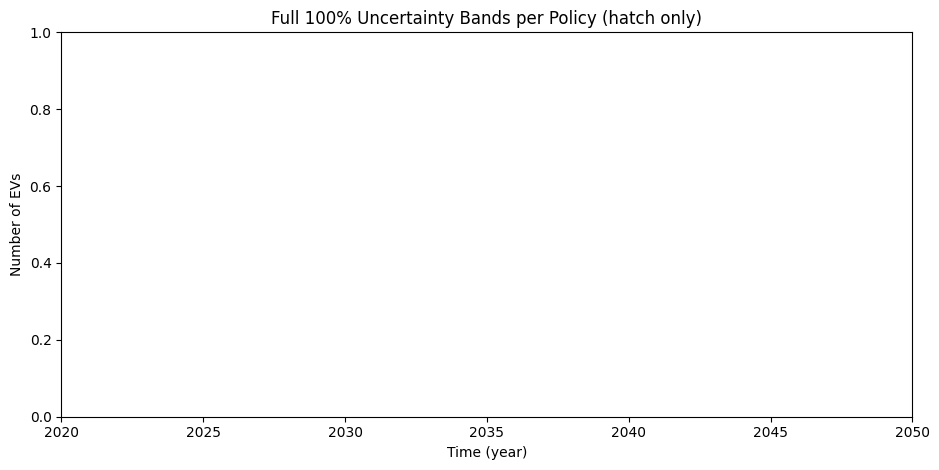

In [20]:
# Plot only two policies (keeps their original colours)
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Number of EVs",
    policy_order=["Base", "ALL_ON"],   # subset of 5 ["Base", "EVTax_ON", "EmissionTax_ON", "Dynaf_HIGH", "ALL_ON"]
)

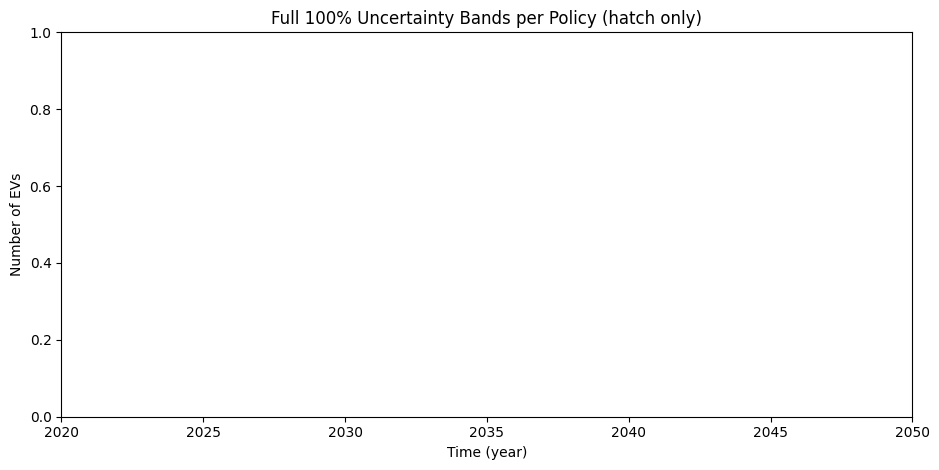

In [21]:
# Plot only two policies (keeps their original colours)
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Number of EVs",
    policy_order=["Base", "EVTax_ON"]   # subset of 5 ["Base", "ALL_ON", "EVTax_ON", "EmissionTax_ON", "Dynaf_HIGH", "ALL_ON"]
)

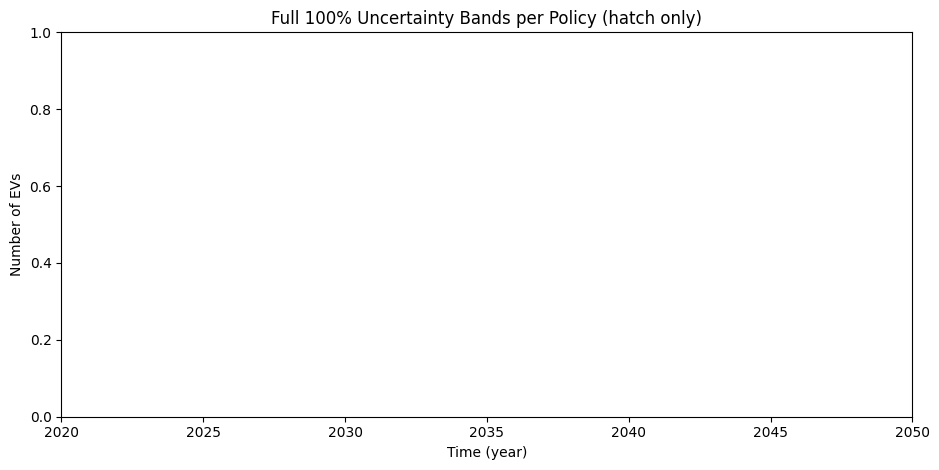

In [22]:
# Plot only two policies (keeps their original colours)
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Number of EVs",
    policy_order=["Base", "EmissionTax_ON"]   # subset of 5 ["Base", "ALL_ON", "EVTax_ON", "EmissionTax_ON", "Dynaf_HIGH", "ALL_ON"]
)

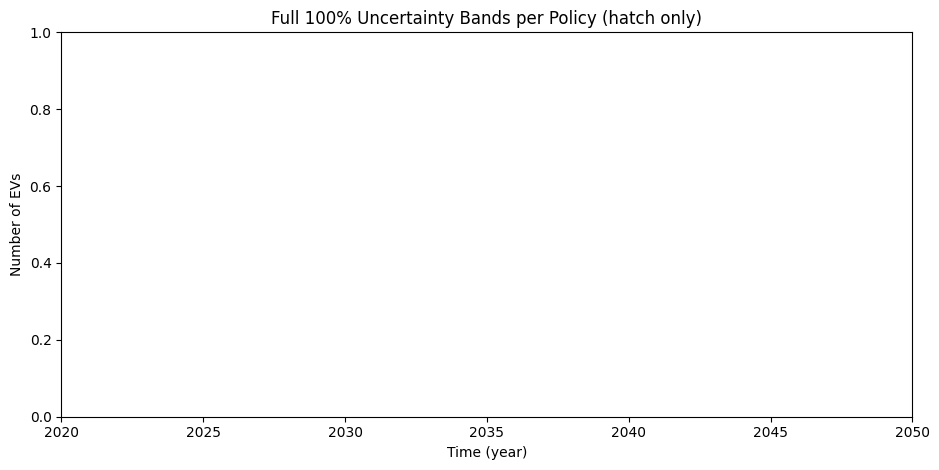

In [23]:
# Plot only two policies (keeps their original colours)
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Number of EVs",
    policy_order=["Base", "Dynaf_HIGH"]   # subset of 5 ["Base", "ALL_ON", "EVTax_ON", "EmissionTax_ON", "Dynaf_HIGH", "ALL_ON"]
)

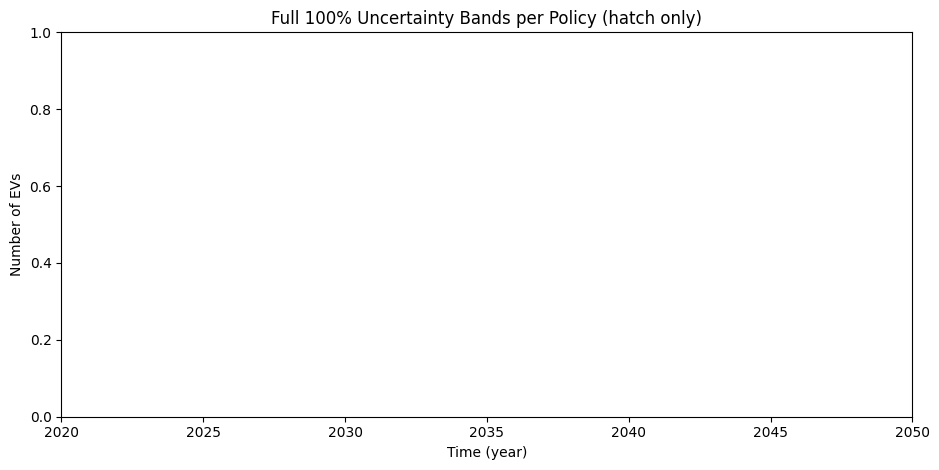

In [18]:
# Plot only two policies (keeps their original colours)
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Number of EVs",
    policy_order=["Base", "Dynaf_HIGH", "EmissionTax_ON"]   # subset of 5 ["Base", "ALL_ON", "EVTax_ON", "EmissionTax_ON", "Dynaf_HIGH", "ALL_ON"]
)

**CO2 Emissions**

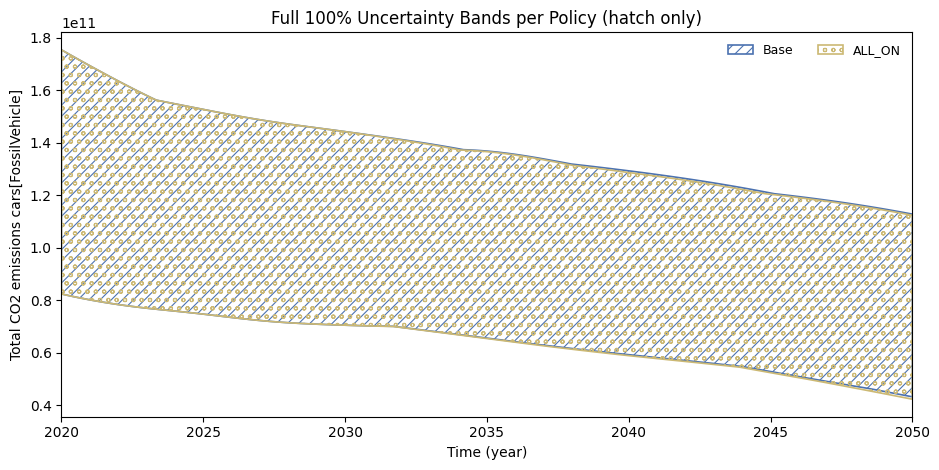

In [39]:
# Another plot for CO2 (still same colour scheme)
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Total CO2 emissions cars[FossilVehicle]",
    policy_order=["Base", "ALL_ON"],
)


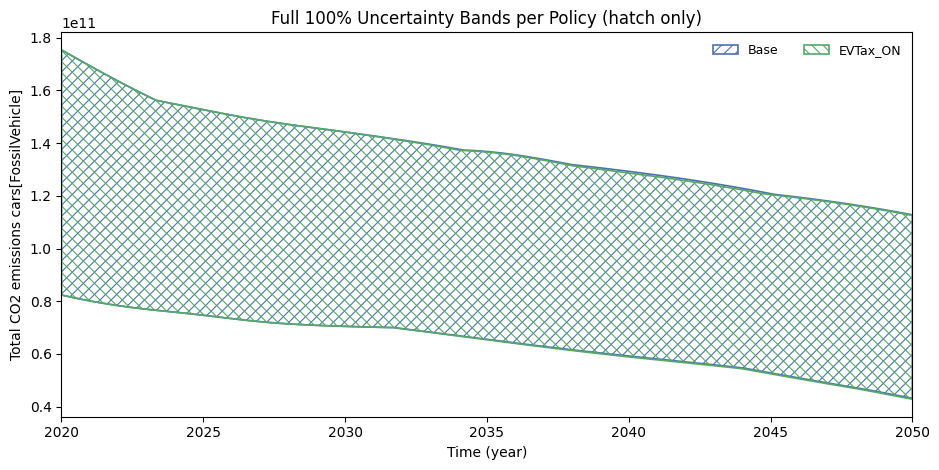

In [42]:
#["Base", "EVTax_ON", "EmissionTax_ON", "Dynaf_HIGH", "ALL_ON"]
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Total CO2 emissions cars[FossilVehicle]",
    policy_order=["Base", "EVTax_ON"])


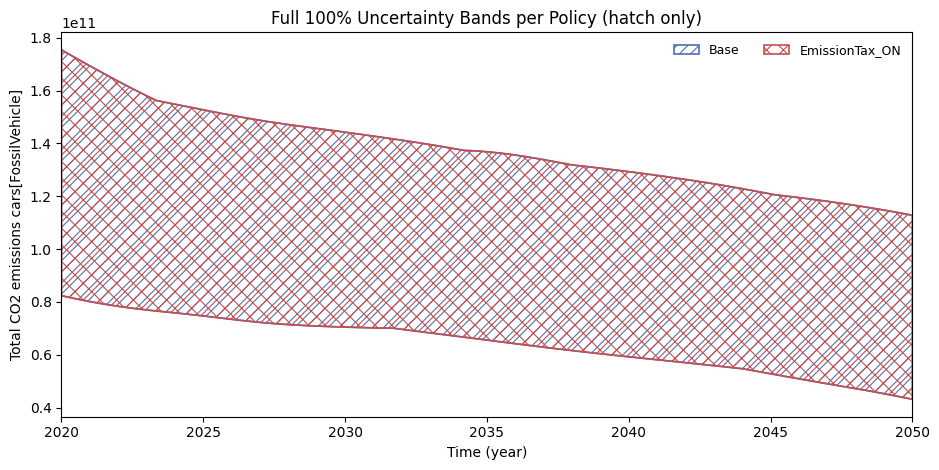

In [41]:
#["Base", "EVTax_ON", "EmissionTax_ON", "Dynaf_HIGH", "ALL_ON"]
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Total CO2 emissions cars[FossilVehicle]",
    policy_order=["Base", "EmissionTax_ON"])


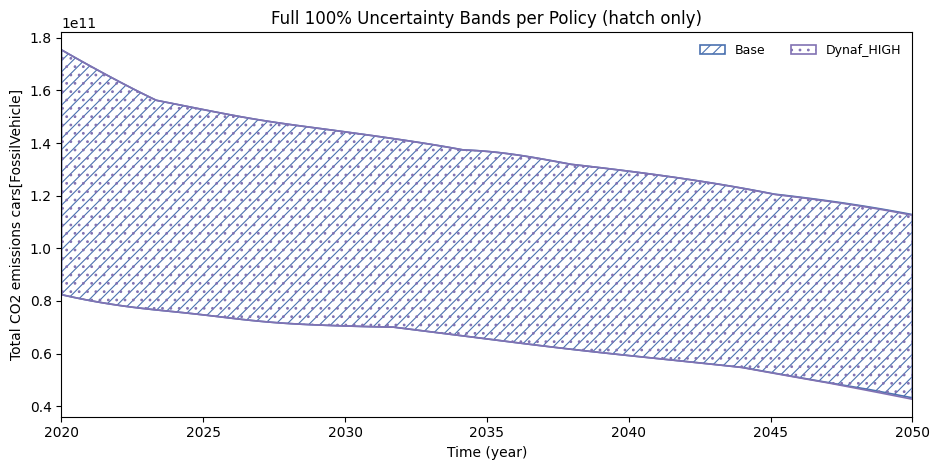

In [43]:
#["Base", "EVTax_ON", "EmissionTax_ON", "Dynaf_HIGH", "ALL_ON"]
plot_hatched_minmax_planes(
    experiments, outcomes,
    outcome_name="Total CO2 emissions cars[FossilVehicle]",
    policy_order=["Base", "Dynaf_HIGH"])
